# Exploratory Data Analysis (EDA)

This notebook gives a first look at the data - what variables are included, where outliers occur, and what kind of distributions are in the dataset. This gives useful background for interpreting results and making modeling decisions.

In [88]:
import itertools

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

# plotting settings for colorblind audiences
sns.set_palette('colorblind')
sns.set_context('notebook')

In [34]:
df = pd.read_csv('winequality-red.csv')

In [35]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Check that the dataset is the expected size of 1599

In [36]:
df.shape

(1599, 12)

Check for null values

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


## Target variable

We examine the distribution of quality ratings to understand the problem better.

We note that:
* Quality ratings are imbalanced in our dataset, with many medium-quality wines (82% of the dataset) and a relatively small number of low (4%) and high quality (14%) wines. We will need to adjust for this imbalance when training models.
* The lowest and highest ratings are 3 and 8 respectively.

In [59]:
# percentages by integer quality rating
df.quality.value_counts()/ df.shape[0] * 100

quality
5    42.589118
6    39.899937
7    12.445278
4     3.314572
8     1.125704
3     0.625391
Name: count, dtype: float64

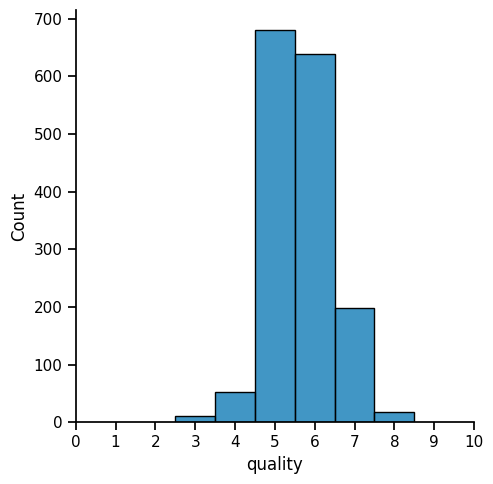

In [54]:
g = sns.displot(data=df, x='quality', discrete=True)
# convert x-axis to range 0-10
g.set(xlim=(0, 10))
# add x ticks for 0-10
g.axes[0,0].set_xticks(range(11));

Define high, low, and mid-performing categories to aid in data descriptions

In [57]:
df['quality_category'] = pd.cut(df['quality'], bins=[0, 4, 6, 10], labels=['low', 'mid', 'high'])

Get percentages of each quality category (low=3-4, mid=4-6, high=7-8)

In [60]:
df.quality_category.value_counts()/ df.shape[0] * 100

quality_category
mid     82.489056
high    13.570982
low      3.939962
Name: count, dtype: float64

# Wine properties

We investigate the distributions and relationships within the wine properties. This will help us choose appropriate data preprocessing, modeling and interpretation steps later on.

Findings summary (with plots in order below):
* There are no individual wine properties which can cleanly separate the high quality wines from low or mid quality. However, high quality wines often have higher alcohol percentages and lower volatile acidity.
* A few wines in the dataset are outliers in sulfur oxide content, sulphates, chlorides, or alcohol. For example wines number 1079 and 1081 have sulfur dioxide content of around 280, while the median across the dataset is 38. We need to be mindful that these extreme values don't skew our models and lead to misleading conclusions.
* Fixed acidity is positively correlated with citric acid and density, and negatively correlated with pH.
* Total sulfur dioxide and free sulfer dioxide are positively correlated.

### Outliers

After a general look at the pairplots, we see there are a few wines with extreme values in terms of total sulfur dioxide, sulphates, chorides, and alcohol. We need to be aware of these extreme values as they may model results.

The boxplots with a layover of individual data points (every point represents a wine) immediately shows a few outliers.

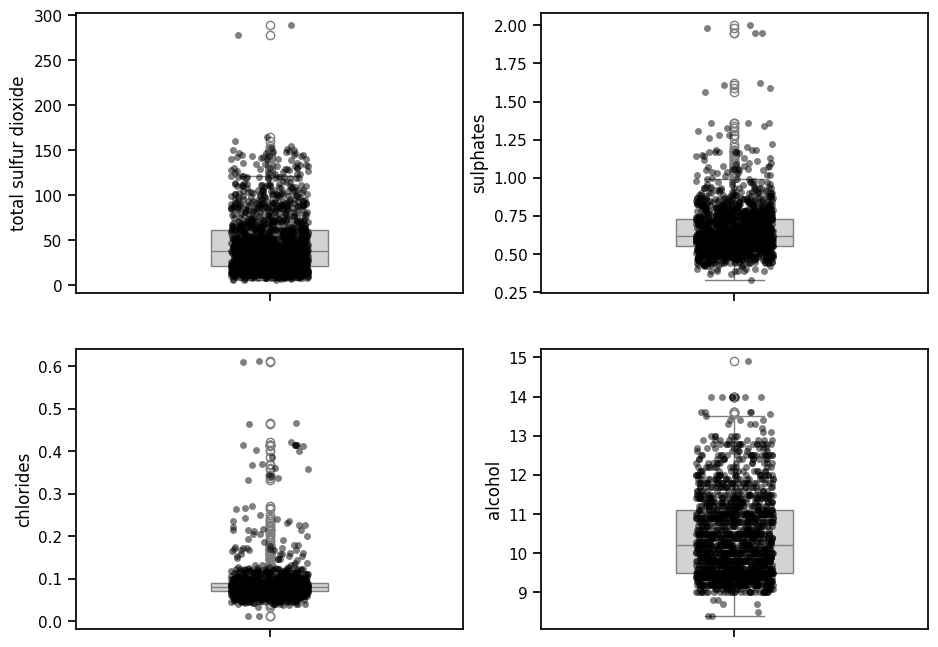

In [130]:
# from the pairplots we identified outliers in these wine properties
outlier_properties = ['total sulfur dioxide', 'sulphates', 'chlorides', 'alcohol']
long_df = df[outlier_properties].melt(var_name='property', value_name='value')
fig, ax = plt.subplots(2, 2, figsize=(11, 8))
for i, prop in enumerate(outlier_properties):
    x, y = i // 2, i % 2
    plotax = ax[x, y]
    # overlay boxplot with individual points
    sns.boxplot(data=long_df[long_df.property == prop], y='value', color='lightgrey', ax=plotax, width=0.3)
    sns.stripplot(data=long_df[long_df.property == prop], y='value', color='black', alpha=0.5, ax=plotax)
    # configure axes labels
    plotax.set_ylabel(prop)

Below are a few calculated descriptive statistics to help us quantify how extreme the outliers are, and some filtering to identify the most extreme wines in total sulfur dioxide and sulphates.

In [131]:
df['total sulfur dioxide'].describe()

count    1599.000000
mean       46.467792
std        32.895324
min         6.000000
25%        22.000000
50%        38.000000
75%        62.000000
max       289.000000
Name: total sulfur dioxide, dtype: float64

In [100]:
df[df['total sulfur dioxide'] > 200]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_category
1079,7.9,0.3,0.68,8.3,0.05,37.5,278.0,0.99316,3.01,0.51,12.3,7,high
1081,7.9,0.3,0.68,8.3,0.05,37.5,289.0,0.99316,3.01,0.51,12.3,7,high


In [101]:
df['sulphates'].describe()

count    1599.000000
mean        0.658149
std         0.169507
min         0.330000
25%         0.550000
50%         0.620000
75%         0.730000
max         2.000000
Name: sulphates, dtype: float64

In [102]:
df[df['sulphates'] > 1.8]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_category
86,8.6,0.49,0.28,1.9,0.11,20.0,136.0,0.9972,2.93,1.95,9.9,6,mid
91,8.6,0.49,0.28,1.9,0.11,20.0,136.0,0.9972,2.93,1.95,9.9,6,mid
92,8.6,0.49,0.29,2.0,0.11,19.0,133.0,0.9972,2.93,1.98,9.8,5,mid
151,9.2,0.52,1.00,3.4,0.61,32.0,69.0,0.9996,2.74,2.00,9.4,4,low


### All-variable plots

The below plots are available for a full overview of the relationships between wine properties.

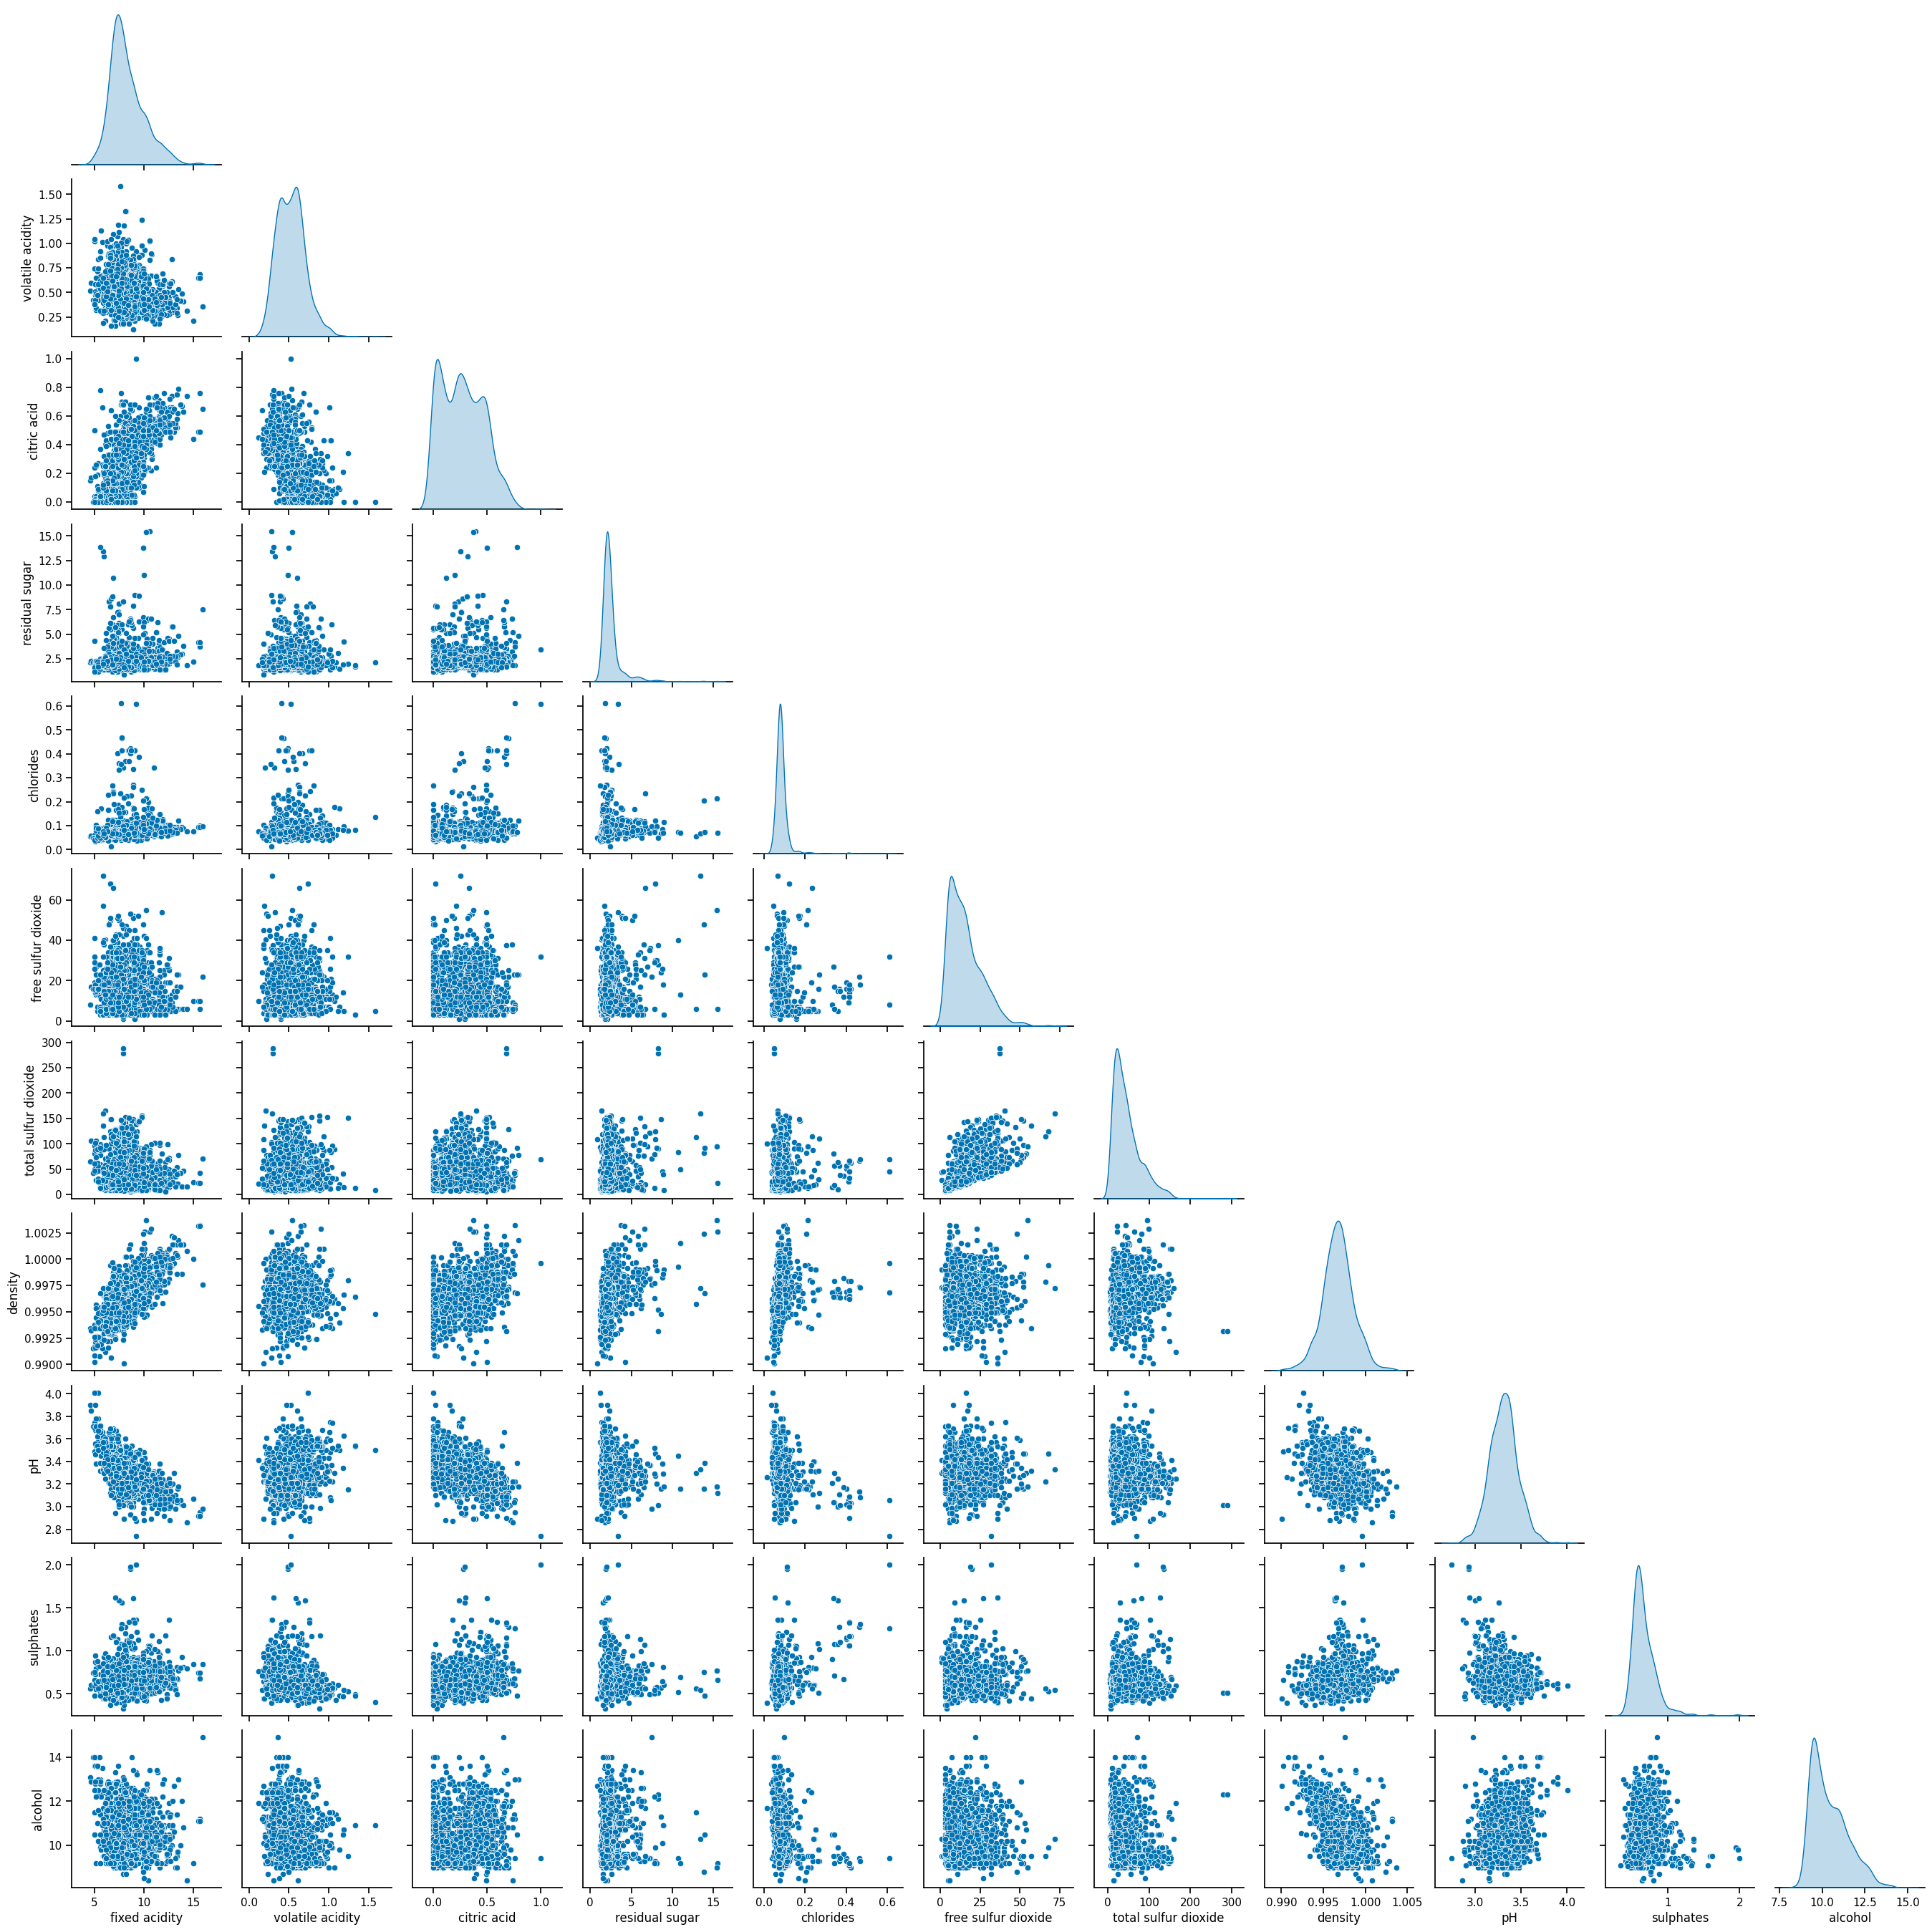

In [135]:
sns.pairplot(df.drop(columns='quality'), diag_kind='kde', corner=True)

### Correlation matrix

The below heatmap shows Pearson's linear correlation coefficients between wine properties, where -1 indicates a strong negative relationship and +1 indicates a strong positive relationship. This also helps us understand which variables are correlated.

A quick glance at this plot helps us identify that alcohol is somewhat positively correlated with quality and negatively correlated with volatile acidity.

<Axes: >

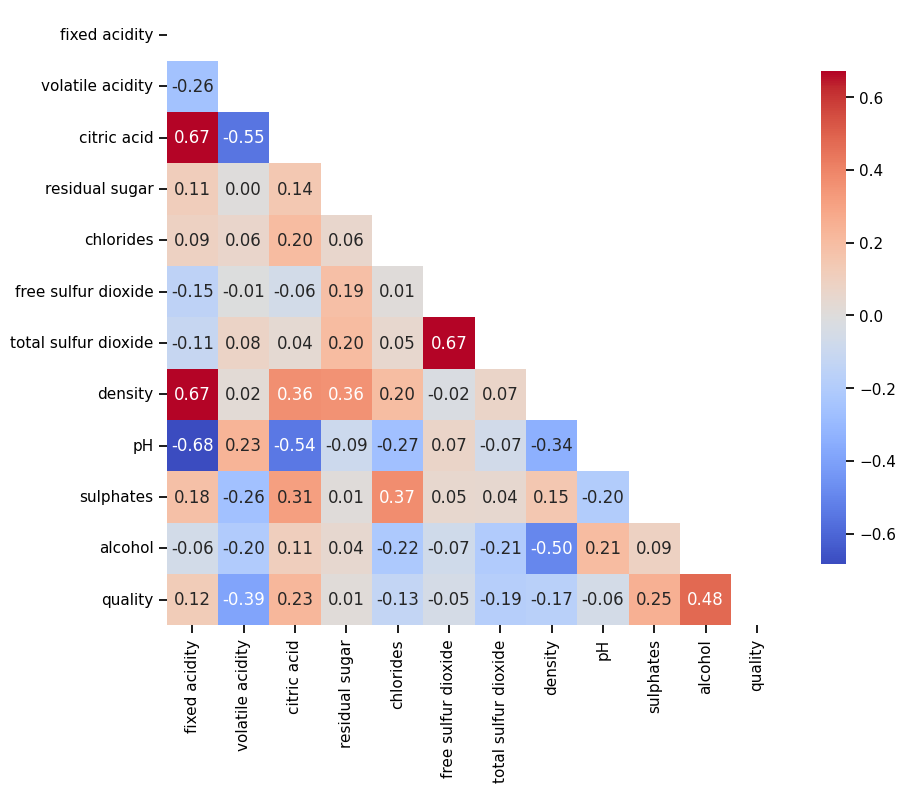

In [136]:
# get correlation matrix
corr = df.drop(columns='quality_category').corr()
# mask the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# initialize a matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, fmt='.2f', square=True, cbar_kws={"shrink": .8}, ax=ax)

### Fixed acidity vs citric acid, density and pH

From an investigation of all pairwise scatterplots in the previous cell, we identify citric acid, density and pH as being correlated. The scatterplots below allow us to zoom in on those relationships and quantify the strength of the relationships. A correlation coefficient of ~.68 indicates a moderately strong correlation.

In [ ]:
# calculate correlation coefficients and p-values for all combinations of variables
corr_stats = {}
# loop over combinations
for var1, var2 in itertools.product(df.drop(columns='quality_category').columns, repeat=2):
    # calculate correlation coefficient and p-value
    r, p = stats.pearsonr(df[var1], df[var2])
    # store in dictionary
    corr_stats[(var1, var2)] = {'r': r, 'p': p}

Text(0.5, 1.0, 'Correlation: -0.68 (p=0.00)')

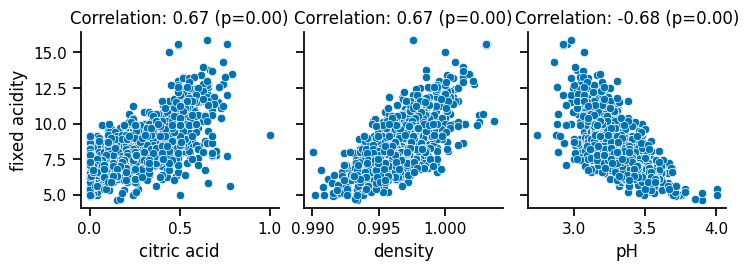

In [133]:
g = sns.pairplot(df, x_vars=['citric acid', 'density', 'pH'], y_vars=['fixed acidity'])
# add correlation coefficient and p-value to the plot titles
g.axes[0, 0].set_title(f'Correlation: {corr_stats[("fixed acidity", "citric acid")]["r"]:.2f} (p={corr_stats[("fixed acidity", "citric acid")]["p"]:.2f})')
g.axes[0, 1].set_title(f'Correlation: {corr_stats[("fixed acidity", "density")]["r"]:.2f} (p={corr_stats[("fixed acidity", "density")]["p"]:.2f})')
g.axes[0, 2].set_title(f'Correlation: {corr_stats[("fixed acidity", "pH")]["r"]:.2f} (p={corr_stats[("fixed acidity", "pH")]["p"]:.2f})')

### Total sulfur dioxide vs free sulfur dioxide

Text(0.5, 1.0, 'Correlation: 0.67 (p=0.00)')

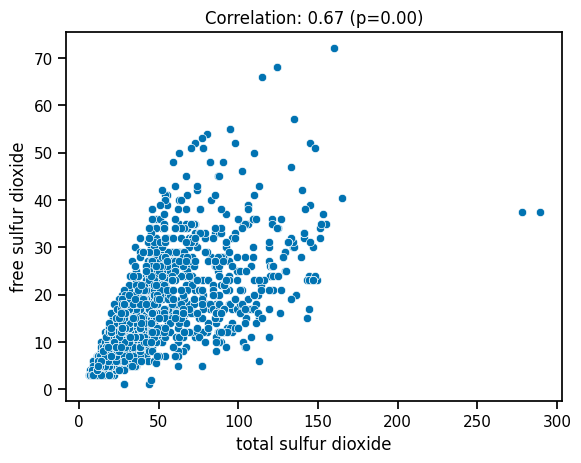

In [134]:
ax = sns.scatterplot(data=df, x='total sulfur dioxide', y='free sulfur dioxide')
ax.set_title('Correlation: {:.2f} (p={:.2f})'.format(corr_stats[('total sulfur dioxide', 'free sulfur dioxide')]['r'], corr_stats[('total sulfur dioxide', 'free sulfur dioxide')]['p']))

### Pairplots by quality category

Coloring the variable plots by wine quality category further help to identify patterns relevant to understand wine quality.

Most of the high quality (green) wines have lower total sulfer dioxide, except the two outlier high quality wines with extremely high total sulfer dioxide content. Later in the modeling process we will want to dig into possible interactions with other variables that help explain why those two wines are still high quality despite their high total sulfer dioxide content.

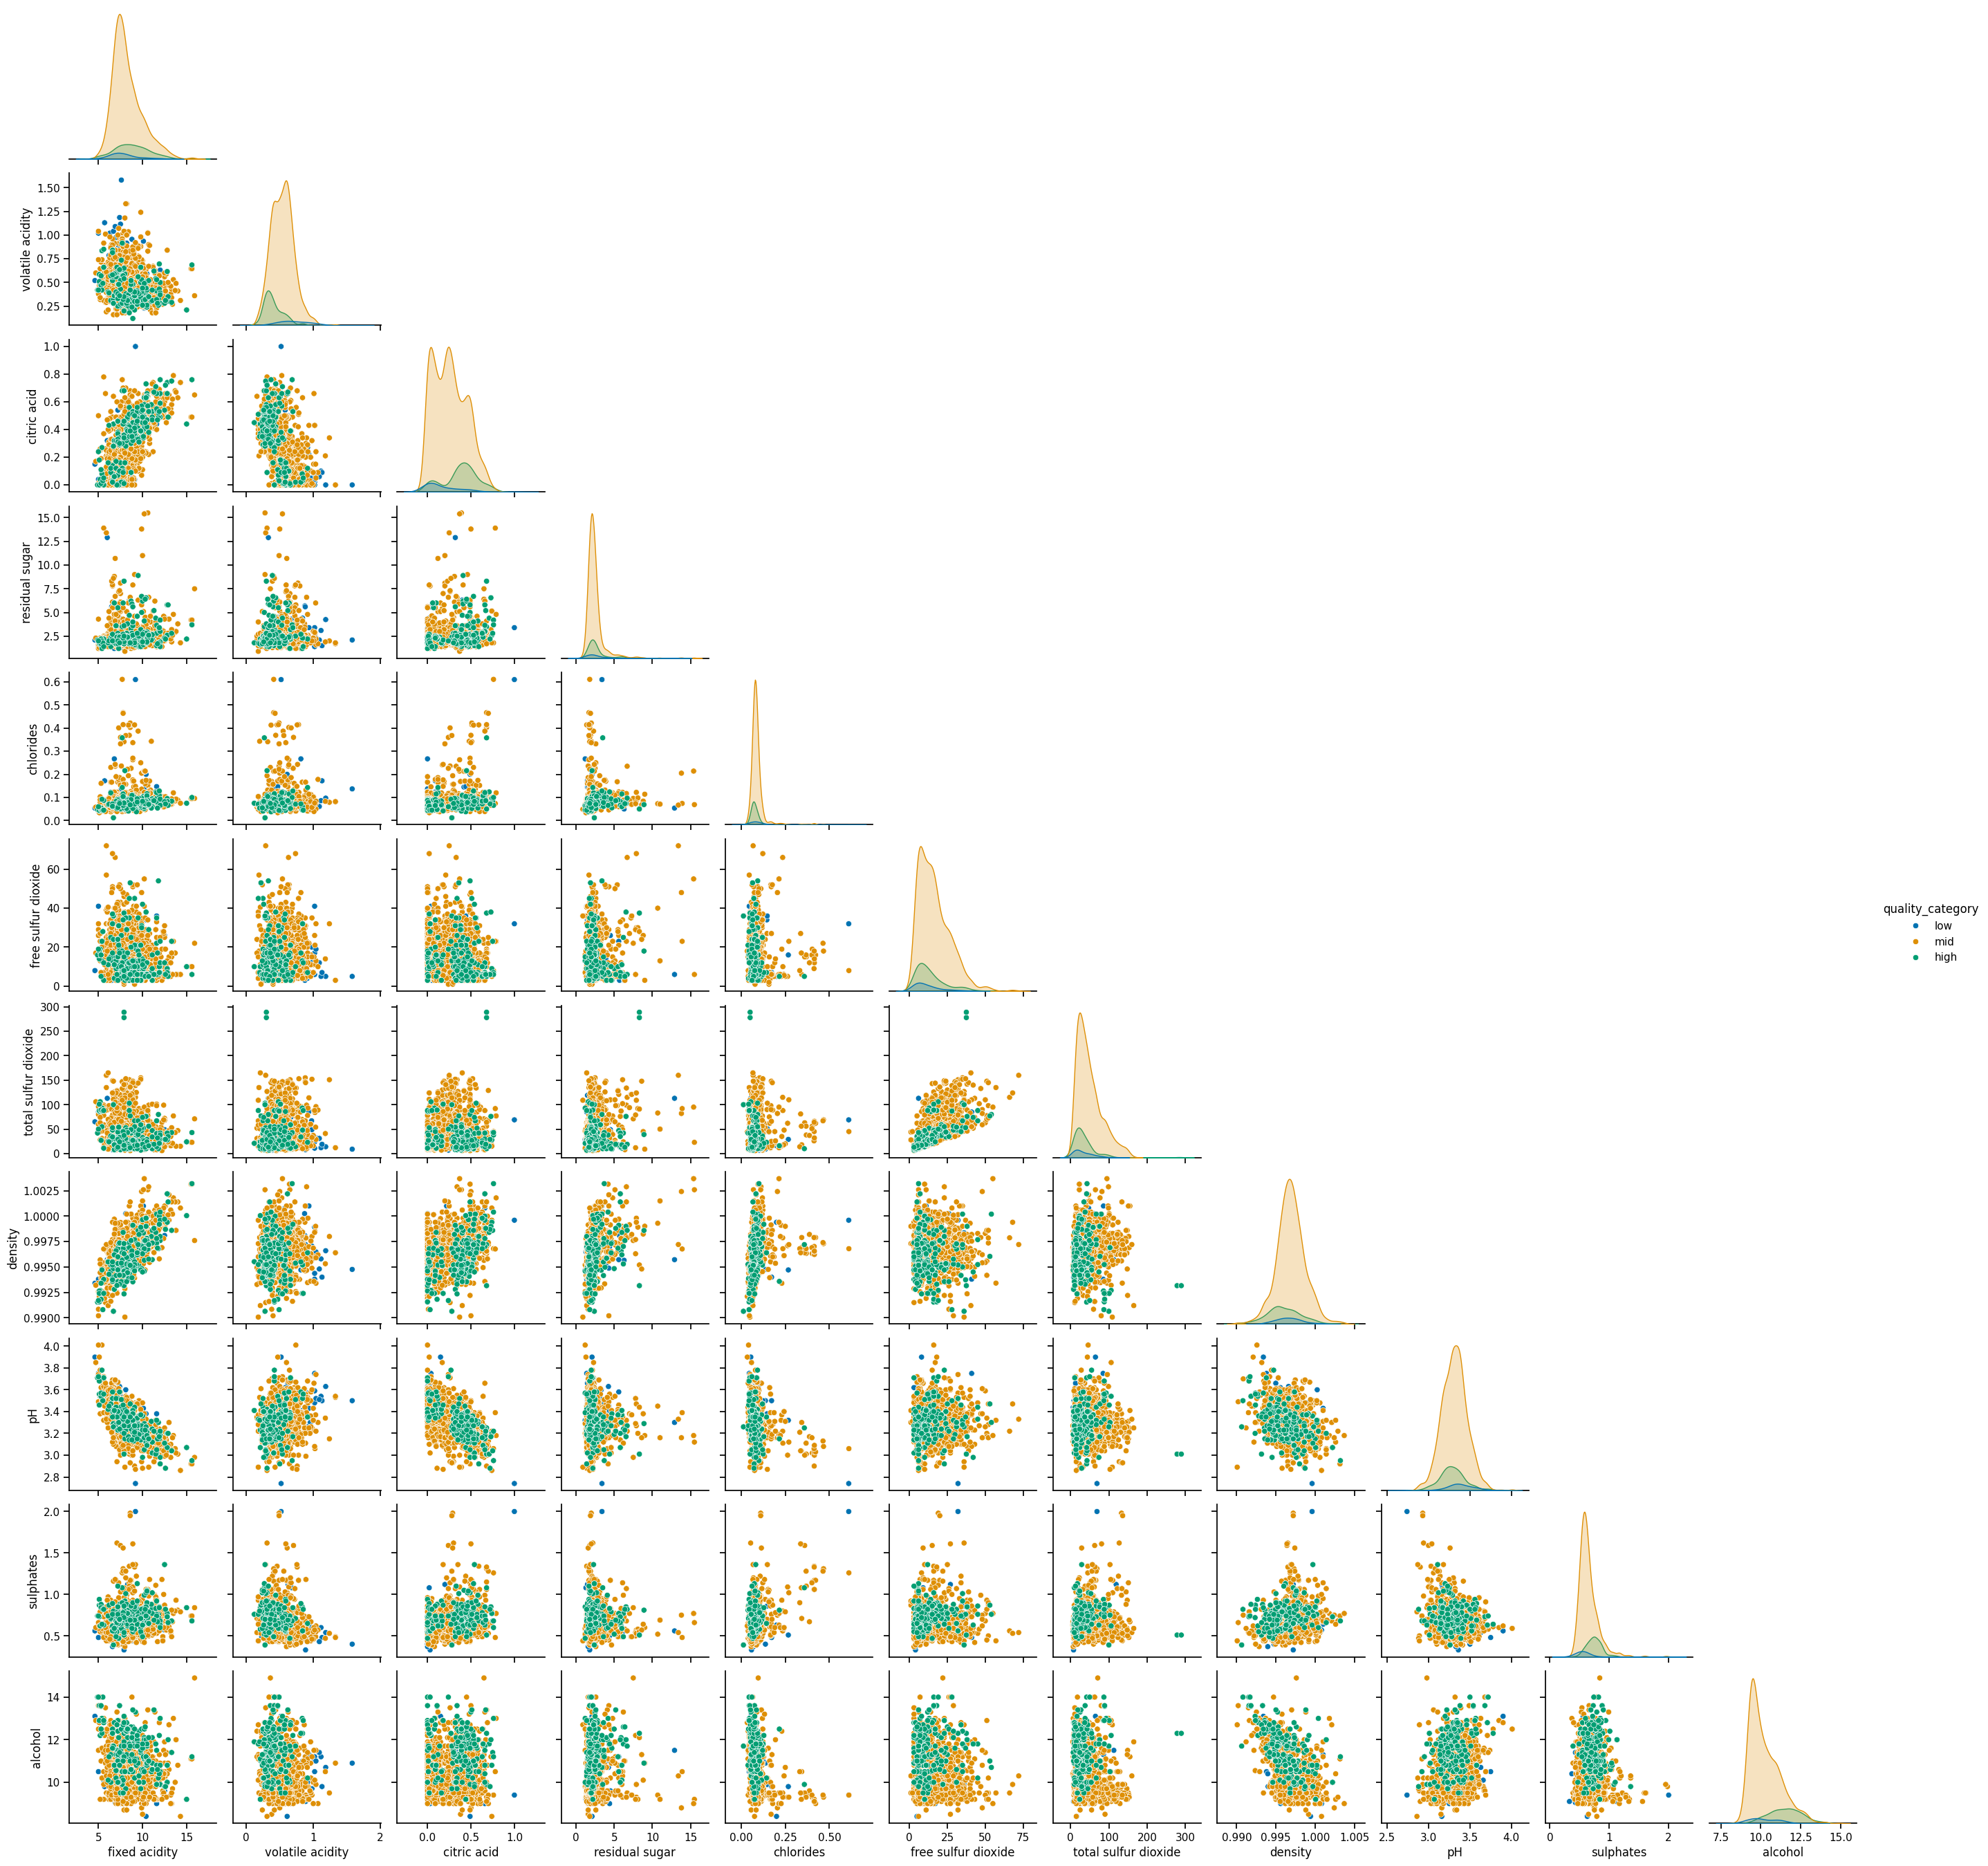

In [141]:
# replot relationships with color differentiation of low, mid, and high quality
sns.pairplot(df.sort_values('quality').drop(columns='quality'), hue='quality_category', diag_kind='kde', corner=True)